In [1]:
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools.constants import kB
from openmmtools.integrators import LangevinIntegrator

from simtk import unit, openmm

from perses.dispersed.utils import configure_platform
from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
import numpy as np
import itertools
import copy

import pickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import mdtraj as md

#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("CUDA")

conducting subsequent work with the following platform: CUDA


DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections'

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


# Generate htf

In [2]:
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from openeye import oechem

DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=6)
           2	LOAD_GLOBAL(arg=0, lineno=6)
           4	LOAD_METHOD(arg=1, lineno=6)
           6	LOAD_CONST(arg=1, lineno=6)
           8	CALL_METHOD(arg=1, lineno=6)
          10	STORE_FAST(arg=2, lineno=6)
          12	LOAD_FAST(arg=0, lineno=7)
          14	LOAD_CONST(arg=2, lineno=7)
          16	BINARY_SUBSCR(arg=None, lineno=7)
          18	LOAD_FAST(arg=1, lineno=7)
          20	LOAD_CONST(arg=3, lineno=7)
          22	BINARY_SUBSCR(arg=None, lineno=7)
          24	BINARY_MULTIPLY(arg=None, lineno=7)
          26	LOAD_FAST(arg=0, lineno=7)
          28	LOAD_CONST(arg=3, lineno=7)
          30	BINARY_SUBSCR(arg=None, lineno=7)
          32	LOAD_FAST(arg=1, lineno=7)
          34	LOAD_CONST(arg=2, lineno=7)
          36	BINARY_SUBSCR(arg=None, lineno=7)
          38	BINARY_MULTIPLY(arg=None, lineno=7)
          40	BINARY_SUBTRACT(arg=None, lineno=7)
          42	LOAD_FAST(arg=2, lineno=7)
          44	LO

DEBUG:numba.core.byteflow:dispatch pc=74, inst=BINARY_MULTIPLY(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$66binary_subscr.30', '$72binary_subscr.33']
DEBUG:numba.core.byteflow:dispatch pc=76, inst=BINARY_SUBTRACT(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$74binary_multiply.34']
DEBUG:numba.core.byteflow:dispatch pc=78, inst=LOAD_FAST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=LOAD_CONST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36']
DEBUG:numba.core.byteflow:dispatch pc=82, inst=STORE_SUBSCR(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36', '$const80.37']
DEBUG:numba.core.byteflow:dispatch pc=84, inst=LOAD_FAST(arg=0, lineno=9)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=9)
DEBUG:numba.core.bytefl

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b59028fef70>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=zeros)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: c = call $4load_method.1($const6.2, func=$4load_method.1, args=[Var($const6.2, coordinate_numba.py:6)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const14.5 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $16binary_subscr.6 = static_getitem(value=a, index=1, index_var=$const14.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const20.8 = const(int, 2)
DEBUG:numba.core.s

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=CALL_METHOD(arg=2, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2', '$a8.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=STORE_FAST(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$10call_method.4']
D

DEBUG:numba.core.byteflow:stack ['$b10.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=UNPACK_SEQUENCE(arg=1, lineno=509)
DEBUG:numba.core.byteflow:stack ['$12load_attr.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=3, lineno=509)
DEBUG:numba.core.byteflow:stack ['$14unpack_sequence.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=2, lineno=510)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8', '$n20.9']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(arg=34, lineno=510)
DEBUG:numba.core.byteflow:stack ['$22compare_op.10']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=26, stack=(), blockstack=(), npush=0), Edge(pc=34, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_ini

DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$12load_attr.5': [<numba.core.ir.Assign object at 0x2b5902b500a0>],
             '$14unpack_sequence.7': [<numba.core.ir.Assign object at 0x2b5902b50220>],
             '$22compare_op.10': [<numba.core.ir.Assign object at 0x2b5902b50820>],
             '$24pred': [<numba.core.ir.Assign object at 0x2b5902b50ac0>],
             '$26load_global.0': [<numba.core.ir.Assign object at 0x2b5902b506a0>],
             '$30call_function.2': [<numba.core.ir.Assign object at 0x2b5902b50e50>],
             '$36return_value.1': [<numba.core.ir.Assign object at 0x2b5902b5e2e0>],
             '$4load_attr.1': [<numba.core.ir.Assign object at 0x2b5902b53a00>],
             '$6unpack_sequence.3': [<numba.core.ir.Assign object at 0x2b5902b53b80>],
             '$const28.1': [<numba.core.ir.Assign object at 0x2b5902b50ca0>],
             '$const34.0': [<numba.core.ir.Assign object at 0x2b5902b5e160>],
             'a': [<numba.core.ir.Assi

DEBUG:numba.core.ssa:on stmt: return $20return_value.1
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$10load_global.0': [<numba.core.ir.Assign object at 0x2b5902bce610>],
             '$14call_function.2': [<numba.core.ir.Assign object at 0x2b5902bce940>],
             '$20return_value.1': [<numba.core.ir.Assign object at 0x2b5902bced90>],
             '$4load_deref.1': [<numba.core.ir.Assign object at 0x2b5902b50fd0>],
             '$6compare_op.2': [<numba.core.ir.Assign object at 0x2b5902bce130>],
             '$8pred': [<numba.core.ir.Assign object at 0x2b5902bce3d0>],
             '$const12.1': [<numba.core.ir.Assign object at 0x2b5902bce790>],
             '$const18.0': [<numba.core.ir.Assign object at 0x2b5902bcec10>],
             'bool8': [<numba.core.ir.Assign object at 0x2b5902bce2b0>],
             'n': [<numba.core.ir.Assign object at 0x2b5902ad4f10>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$axis4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=22)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.core.byteflow:di

DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_FAST(arg=0, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_CONST(arg=2, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_SUBSCR(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39', '$const130.40']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=LOAD_FAST(arg=6, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=BINARY_MULTIPLY(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41', '$sin_angle134.42']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=BINARY_SUBTRACT(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$136binary_multiply.43']
DEBUG:numba.core.byteflo

DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88']
DEBUG:numba.core.byteflow:dispatch pc=236, inst=LOAD_FAST(arg=5, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89']
DEBUG:numba.core.byteflow:dispatch pc=238, inst=BINARY_SUBTRACT(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89', '$cos_angle236.90']
DEBUG:numba.core.byteflow:dispatch pc=240, inst=BINARY_MULTIPLY(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$238binary_subtract.91']
DEBUG:numba.core.byteflow:dispatch pc=242, inst=BINARY_ADD(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$240binary_multiply.92']
DEBUG:numba.core.byteflow:dispatch pc=244, inst=LOAD_FAST(arg=7, lineno=36)
DEBUG:numba.core.byteflow:stack ['$242binary_add.93']
DEBUG:numba.core.byteflow:dispatch pc=246, inst=LOAD_CONST(arg=12, lineno=36)
D

DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$axis336.137', '$const338.138']
DEBUG:numba.core.byteflow:dispatch pc=342, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$340binary_subscr.139']
DEBUG:numba.core.byteflow:dispatch pc=344, inst=LOAD_CONST(arg=6, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140']
DEBUG:numba.core.byteflow:dispatch pc=346, inst=LOAD_FAST(arg=5, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141']
DEBUG:numba.core.byteflow:dispatch pc=348, inst=BINARY_SUBTRACT(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141', '$cos_angle346.142']
DEBUG:numba.core.byteflow:dispatch pc=350, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$348binary_subtract.143']
DEBUG:numba.core.byteflow:dispatch pc=352, inst=LOAD_FAST(arg=0, lineno=40)
DEBUG:numba.core.byt

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))}})
DEBUG:numba.core.byteflow:keep phismap: {'$phi18.0': {('$16get_iter.6', State(pc_initial=0 nstack_initial=0))},
 '$phi20.1': {('$18for_iter.2', State(pc_initial=18 nstack_initial=1))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi18.0': '$16get_iter.6'},
             State(pc_initial=18 nstack_initial=1): {'$phi20.1': '$18for_iter.2'}})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(in

DEBUG:numba.core.interpreter:label 0:
    axis = arg(0, name=axis)                 ['axis']
    angle = arg(1, name=angle)               ['angle']
    $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>)) ['$2load_global.0']
    axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None) ['$2load_global.0', 'axis', 'axis_norm']
    $10load_global.3 = global(range: <class 'range'>) ['$10load_global.3']
    $const12.4 = const(int, 3)               ['$const12.4']
    $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None) ['$10load_global.3', '$14call_function.5', '$const12.4']
    $16get_iter.6 = getiter(value=$14call_function.5) ['$14call_function.5', '$16get_iter.6']
    $phi18.0 = $16get_iter.6                 ['$16get_iter.6', '$phi18.0']
    jump 18                                  []
label 18:
    $18

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5902c2be80>
DEBUG:numba.core.ssa:on stmt: axis = arg(0, name=axis)
DEBUG:numba.core.ssa:on stmt: angle = arg(1, name=angle)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $const12.4 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $16get_iter.6 = getiter(value=$14call_function.5)
DEBUG:numba.core.ssa:on stmt: $phi18.0 = $16get_iter.6
DEBUG:numba.core.ssa:on stm

DEBUG:numba.core.ssa:on stmt: $198binary_multiply.72 = $190binary_subscr.68 * $196binary_subscr.71
DEBUG:numba.core.ssa:on stmt: $const200.73 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $204binary_subtract.75 = $const200.73 - cos_angle
DEBUG:numba.core.ssa:on stmt: $206binary_multiply.76 = $198binary_multiply.72 * $204binary_subtract.75
DEBUG:numba.core.ssa:on stmt: $const210.78 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $212binary_subscr.79 = static_getitem(value=axis, index=2, index_var=$const210.78, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $216binary_multiply.81 = $212binary_subscr.79 * sin_angle
DEBUG:numba.core.ssa:on stmt: $218binary_add.82 = $206binary_multiply.76 + $216binary_multiply.81
DEBUG:numba.core.ssa:on stmt: $const_1.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $const_0.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const222.84 = build_tuple(items=[Var($const_1.1, coordinate_numba.py:35), Var($const_0.4, coordinate_numba.py:35)])
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=22)
           2	LOAD_FAST(arg=0, lineno=22)
           4	LOAD_CONST(arg=1, lineno=1)
           6	BINARY_POWER(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_POWER(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$

DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_DEREF(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_FUNCTION(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3', '$a12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$14call_function.5']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=1, lineno=219)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_CONST(arg=2, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=0, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6', '$const20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(ar

DEBUG:numba.core.byteflow:stack ['$exp130.0']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=COMPARE_OP(arg=3, lineno=238)
DEBUG:numba.core.byteflow:stack ['$exp130.0', '$const132.1']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=POP_JUMP_IF_FALSE(arg=172, lineno=238)
DEBUG:numba.core.byteflow:stack ['$134compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=138, stack=(), blockstack=(), npush=0), Edge(pc=172, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=60 nstack_initial=0), State(pc_initial=76 nstack_initial=0), State(pc_initial=138 nstack_initial=0), State(pc_initial=172 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_DEREF(arg=2, lineno=226)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=POP_JUMP_IF_FALSE(arg=68, lineno=226)
DEBUG:numba.core.byteflow:stack ['$60load_deref.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(

DEBUG:numba.core.byteflow:dispatch pc=160, inst=STORE_FAST(arg=4, lineno=241)
DEBUG:numba.core.byteflow:stack ['$158inplace_rshift.2']
DEBUG:numba.core.byteflow:dispatch pc=162, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=164, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3']
DEBUG:numba.core.byteflow:dispatch pc=166, inst=INPLACE_MULTIPLY(arg=None, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3', '$a164.4']
DEBUG:numba.core.byteflow:dispatch pc=168, inst=STORE_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$166inplace_multiply.5']
DEBUG:numba.core.byteflow:dispatch pc=170, inst=JUMP_ABSOLUTE(arg=130, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=130, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=176 nstack_initial=0), State(pc_initial=184 nstack_initial=0), State(pc_initial=92 n

DEBUG:numba.core.byteflow:block_infos State(pc_initial=84 nstack_initial=0):
AdaptBlockInfo(insts=((84, {'res': '$a84.0'}), (86, {'res': '$const86.1'}), (88, {'lhs': '$a84.0', 'rhs': '$const86.1', 'res': '$88compare_op.2'}), (90, {'pred': '$88compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={92: (), 106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=92 nstack_initial=0):
AdaptBlockInfo(insts=((92, {'res': '$const92.0'}), (94, {'retval': '$const92.0', 'castval': '$94return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=98 nstack_initial=0):
AdaptBlockInfo(insts=((98, {'res': '$const98.0'}), (100, {'value': '$const98.0'}), (102, {'res': '$b102.1'}), (104, {'value': '$b102.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=106 nstack_i

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5902cdb2b0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22c

DEBUG:numba.core.ssa:SSA violators {'invert', 'exp', 'r', 'a.1'}
DEBUG:numba.core.ssa:Fix SSA violator on var invert
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902cdb2b0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb400>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22compare_o

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb400>
DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb400>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Fix SSA violator on var exp
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d14dc0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d14dc0>
DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d14dc0>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {26: [<numba.core.ir.Assign object at 0x2b5902d14d90>],
             98: [<numba.core.ir.Assign object at 0x2b5902cdb6a0>],
             154: [<numba.core.ir.Assign object at 0x2b5902d4d4f0>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.c

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 146
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb610>
DEBUG:numba.core.ssa:on stmt: $150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=r, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: r = $150inplace_multiply.2
DEBUG:numba.core.ssa:on stmt: jump 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 154
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb610>
DEBUG:numba.core.ssa:on stmt: $const156.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp, rhs=$const156.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:find_def var='exp' stmt=$158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp

DEBUG:numba.core.ssa:on stmt: $const132.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $134compare_op.2 = exp.4 != $const132.1
DEBUG:numba.core.ssa:on stmt: bool136 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var($134compare_op.2, numbers.py:238),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $136pred, 138, 172
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 138
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902c5d370>
DEBUG:numba.core.ssa:on stmt: $const140.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $142binary_and.2 = exp.4 & $const140.1
DEBUG:numba.core.ssa:on stmt: bool144 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $144pred = call bool144($142binary_and.2, func=bool144, args=(Var($142binary_and.2, numbers.py:239),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $144pred, 146, 154
DEBUG:numba.core.ssa:==== SSA block rewrite

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 130
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902d14cd0>
DEBUG:numba.core.ssa:on stmt: exp.4 = phi(incoming_values=[Var(exp.3, numbers.py:235), Var(exp.2, numbers.py:241)], incoming_blocks=[106, 154])
DEBUG:numba.core.ssa:on stmt: $const132.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $134compare_op.2 = exp.4 != $const132.1
DEBUG:numba.core.ssa:on stmt: bool136 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var($134compare_op.2, numbers.py:238),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $136pred, 138, 172
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 138
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902d14cd0>
DEBUG:numba.core.ssa:on stmt: $const140.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $142binary_and.2 = exp.4 & $const140.1
DEBUG:numba.core.ssa:on stmt: bool144 = glob

DEBUG:numba.core.ssa:on stmt: branch $42pred, 44, 48
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 44
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d4de80>
DEBUG:numba.core.ssa:on stmt: $44load_global.0 = global(OverflowError: <class 'OverflowError'>)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d4de80>
DEBUG:numba.core.ssa:on stmt: $48load_deref.0 = freevar(is_integer: False)
DEBUG:numba.core.ssa:on stmt: bool50 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $50pred = call bool50($48load_deref.0, func=bool50, args=(Var($48load_deref.0, numbers.py:224),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 98
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d4de80>
DEBUG:numba.core.ssa:o

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb2b0>
DEBUG:numba.core.ssa:on stmt: invert = const(bool, True)
DEBUG:numba.core.ssa:on stmt: exp = unary(fn=<built-in function neg>, value=b)
DEBUG:numba.core.ssa:on stmt: $const38.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $40compare_op.5 = exp < $const38.4
DEBUG:numba.core.ssa:on stmt: bool42 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $42pred = call bool42($40compare_op.5, func=bool42, args=(Var($40compare_op.5, numbers.py:222),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $42pred, 44, 48
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 44
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb2b0>
DEBUG:numba.core.ssa:on stmt: $44load_global.0 = global(OverflowError: <class 'OverflowError'>)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <n

DEBUG:numba.core.ssa:idom 138 from label 154
DEBUG:numba.core.ssa:find_def_from_bottom label 138
DEBUG:numba.core.ssa:find_def_from_top label 138
DEBUG:numba.core.ssa:idom 130 from label 138
DEBUG:numba.core.ssa:find_def_from_bottom label 130
DEBUG:numba.core.ssa:replaced with: $166inplace_multiply.5 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=a.1.2, rhs=a.1.2, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: a.1.1 = $166inplace_multiply.5
DEBUG:numba.core.ssa:on stmt: jump 130
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 172
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902cdb2b0>
DEBUG:numba.core.ssa:on stmt: bool174 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $174pred = call bool174(invert.2, func=bool174, args=(Var(invert.2, numbers.py:244),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $174pred, 176, 184
DEBUG:numba.core.ssa:==== SSA block rewrite pas

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=44, inst=LOAD_FAST(arg=5, lineno=214)
DEBUG:numba.core.byteflow:stack ['$dest_shape42.3']
DEBUG:numba.core.byteflow:dispatch pc=46, inst=BINARY_SUBSCR(arg=None, lineno=214)
DEBUG:numba.core.byteflow:stack ['$dest_shape42.3', '$dest_index44.4']
DEBUG:numba.core.byteflow:dispatch pc=48, inst=STORE_FAST(arg=7, lineno=214)
DEBUG:numba.core.byteflow:stack ['$46binary_subscr.5']
DEBUG:numba.core.byteflow:dispatch pc=50, inst=LOAD_FAST(arg=7, lineno=217)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=52, inst=LOAD_CONST(arg=2, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6']
DEBUG:numba.core.byteflow:dispatch pc=54, inst=COMPARE_OP(arg=3, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6', '$const52.7']
DEBUG:numba.core.byteflow:dispatch pc=56, inst=POP_JUMP_IF_FALSE(arg=86, lineno=217)
DEBUG:numba.core.byteflow:stack ['$54compare_op.8']
DEBUG:numba.core.byteflow

DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=10 nstack_initial=0): set(),
             State(pc_initial=14 nstack_initial=0): set(),
             State(pc_initial=26 nstack_initial=0): set(),
             State(pc_initial=34 nstack_initial=0): set(),
             State(pc_initial=58 nstack_initial=0): set(),
             State(pc_initial=66 nstack_initial=0): set(),
             State(pc_initial=74 nstack_initial=0): set(),
             State(pc_initial=86 nstack_initial=0): set(),
             State(pc_initial=94 nstack_initial=0): set(),
             State(pc_initial=102 nstack_initial=0): set(),
             State(pc_initial=120 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing p

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5902dc6d90>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block analysis pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5902dc6d90>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=

DEBUG:numba.core.ssa:SSA violators {'dest_index', 'src_index'}
DEBUG:numba.core.ssa:Fix SSA violator on var dest_index
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902c5d460>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902c5d460>
DEBUG

DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902d06d30>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='dest_index' stmt=dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:find_def_from_top label 26
DEBUG:numba.core.ssa:insert phi node dest_index.2 = phi(incoming_values=[], incoming

DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d068e0>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=$const10.0)
DEBUG:numba.core.ssa:on stmt: return $12return_value.1
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 14
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5902d068e0>
DEBUG:numba.core.ssa:on stmt: src_index = const(int, 0)
DEBUG:numba.core.ssa:first assign: src_index
DEBUG:numba.core.ssa:replaced with: src_index = const(int, 0)
DEBUG:numba.core.ssa:on stmt: dest_index = dest_ndim - src_ndim
DEBUG:numba.core.ssa:on stmt: jump 26
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 26
DEBUG:numba.c

DEBUG:numba.core.ssa:incoming_def src_index = const(int, 0)
DEBUG:numba.core.ssa:replaced with: $30compare_op.2 = src_index.2 < src_ndim
DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b5902dc6a30>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='src_index' stmt=src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:replaced with: src_dim_size = ge

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=3, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBSCR(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=4, lineno=47)
DEBUG:numba.core.byteflow:stack ['$6binary_subscr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=3, lineno=48)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=2, lineno=48)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates10.3']


DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=120, inst=STORE_FAST(arg=16, lineno=68)
DEBUG:numba.core.byteflow:stack ['$a_u118.46']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_GLOBAL(arg=2, lineno=69)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=124, inst=LOAD_FAST(arg=16, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47']
DEBUG:numba.core.byteflow:dispatch pc=126, inst=LOAD_FAST(arg=6, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48']
DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_GLOBAL(arg=3, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_ATTR(arg=5, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49', '$128load_global.50']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_ADD(arg=None, lineno=69)
D

DEBUG:numba.core.interpreter:label 0:
    bond_position = arg(0, name=bond_position) ['bond_position']
    angle_position = arg(1, name=angle_position) ['angle_position']
    torsion_position = arg(2, name=torsion_position) ['torsion_position']
    internal_coordinates = arg(3, name=internal_coordinates) ['internal_coordinates']
    $const4.1 = const(int, 0)                ['$const4.1']
    r = getitem(value=internal_coordinates, index=$const4.1, fn=<built-in function getitem>) ['$const4.1', 'internal_coordinates', 'r']
    $const12.4 = const(int, 1)               ['$const12.4']
    theta = getitem(value=internal_coordinates, index=$const12.4, fn=<built-in function getitem>) ['$const12.4', 'internal_coordinates', 'theta']
    $const20.7 = const(int, 2)               ['$const20.7']
    phi = getitem(value=internal_coordinates, index=$const20.7, fn=<built-in function getitem>) ['$const20.7', 'internal_coordinates', 'phi']
    a = angle_position - bond_position       ['a', 'angle_position

DEBUG:numba.core.ssa:on stmt: angle_rotation_matrix = call $96load_global.37(angle_axis, theta, func=$96load_global.37, args=[Var(angle_axis, coordinate_numba.py:61), Var(theta, coordinate_numba.py:48)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $106load_global.41 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $108load_method.42 = getattr(value=$106load_global.41, attr=dot)
DEBUG:numba.core.ssa:on stmt: d_ang = call $108load_method.42(angle_rotation_matrix, d_r, func=$108load_method.42, args=[Var(angle_rotation_matrix, coordinate_numba.py:62), Var(d_r, coordinate_numba.py:56)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: torsion_axis = a_u
DEBUG:numba.core.ssa:on stmt: $122load_global.47 = global(_rotation_matrix: CPUDispatcher(<function _rotation_matrix at 0x2b59029b9ee0>))
DEBUG:numba.core.ssa:on stmt: $128load_global.50 = global(np: <module 'numpy

DEBUG:numba.core.interpreter:label 0:
    angle_position_1 = arg(0, name=angle_position_1) ['angle_position_1']
    bond_position_1 = arg(1, name=bond_position_1) ['bond_position_1']
    $6binary_subtract.2 = angle_position_1 - bond_position_1 ['$6binary_subtract.2', 'angle_position_1', 'bond_position_1']
    $8return_value.3 = cast(value=$6binary_subtract.2) ['$6binary_subtract.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5902d81070>
DEBUG:numba.core.ssa:on stmt: angle_position_1 = arg(0, name=angle_position_1)
DEBUG:numba.core.ssa:on stmt: bond_position_1 = arg(1, name=bond_position_1)
DEBUG:numba.core.ssa:on stmt: $6binary_subtract.2 = angle_position_1 - bond_position_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_subtract.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=51)
           2	LOAD_FAST(arg=1, lineno=51)
           4	LOAD_FAST(arg=0, lineno=54)
           6	BINARY_TRUE_DIVIDE(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=1, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=54)
DEBUG:numba.core.byteflow:stack ['$b_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$b_12.0', '$_60call_function_23_14.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.c

DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$normal_12.0'}), (4, {'res': '$_90call_function_35_14.1'}), (6, {'lhs': '$normal_12.0', 'rhs': '$_90call_function_35_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _90call_function_35_1 = arg(0, name=_90call_function_35_1) ['_90call_function_35_1']
    normal_1 = arg(1, name=normal_1)         ['normal_1']
    $6binary_true_divide.2 = normal_1 / _90call_function_35_1 ['$6binary_true_divide.2', '_90call_function_35_1', 'normal_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.

DEBUG:numba.core.byteflow:stack ['$56call_method.6']
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_GLOBAL(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=LOAD_METHOD(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$60load_global.7']
DEBUG:numba.core.byteflow:dispatch pc=64, inst=LOAD_FAST(arg=0, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=LOAD_FAST(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9']
DEBUG:numba.core.byteflow:dispatch pc=68, inst=LOAD_FAST(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10']
DEBUG:numba.core.byteflow:dispatch pc=70, inst=CALL_METHOD(arg=3, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10', '$out68.11']
DEBUG:numba.core.byteflow:dispatch pc=72, inst=RETURN_VALUE(arg=None, lineno=490)
DEBUG:numba.core.byteflow:stack ['$70c

DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequence.8 = exhaust_iter(value=$14load_attr.6, count=1)
DEBUG:numba.core.ssa:on stmt: _n = static_getitem(value=$16unpack_sequence.8, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.co

DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3', '$6unpack_sequence.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=STORE_FAST(arg=4, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=0, lineno=572)
DEBUG:numba.core.byteflow:stack ['$b12.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=UNPACK_SEQUENCE(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack ['$14load_attr.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=STORE_FAST(arg=5, lineno=572)
DEBUG:numba.core.byteflow:stack ['$16unpack_sequence.7']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=5, lineno=573)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=22, inst=LOAD_FAST(arg=4, lineno=573)
DEBUG:numba.core.byteflow:st

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5903008c40>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: out = arg(2, name=out)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: _n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequenc

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b590302c370>
DEBUG:numba.core.ssa:on stmt: bond_position_2 = arg(0, name=bond_position_2)
DEBUG:numba.core.ssa:on stmt: d_torsion_1 = arg(1, name=d_torsion_1)
DEBUG:numba.core.ssa:on stmt: $6binary_add.2 = bond_position_2 + d_torsion_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_add.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_add.2': [<numba.core.ir.Assign object at 0x2b5903029790>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x2b59030621c0>],
             'bond_position_2': [<numba.core.ir.Assign object at 0x2b5903029190>],
             'd_torsion_1': [<numba.core.ir.Assign object at 0x2b590301ee20>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=80)

DEBUG:numba.core.byteflow:dispatch pc=64, inst=STORE_SUBSCR(arg=None, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12', '$xyzs60.13', '$i62.14']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=JUMP_ABSOLUTE(arg=32, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=32, stack=('$phi34.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=32 nstack_initial=1)])
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=32 nstack_initial=1): {'$phi32.0'},
             State(pc_initial=34 nstack_initial=2): {'$phi34.1'},
             State(pc_initial=68 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {'$phi32.0': State(pc_initial=0 nstack_initial=0),
 '$phi34.1': State(pc_initial=3

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5903167190>
DEBUG:numba.core.ssa:on stmt: bond_position = arg(0, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(1, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(2, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: internal_coordinates = arg(3, name=internal_coordinates)
DEBUG:numba.core.ssa:on stmt: phi_set = arg(4, name=phi_set)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: n_phis = call $2load_global.0(phi_set, func=$2load_global.0, args=[Var(phi_set, coordinate_numba.py:80)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_method.4 = get

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0', '$bond_position4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=89)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=90)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=BINARY_SUBTRACT(arg=None, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3', '$bond_position12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=4, lineno=90)
DEBUG:numba.core.byteflow:stack ['$14binary_subtract.5']
DEBUG:numba.

DEBUG:numba.core.byteflow:block_infos State(pc_initial=62 nstack_initial=0):
AdaptBlockInfo(insts=((62, {'res': '$const62.0'}), (64, {'value': '$const62.0'}), (66, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=68 nstack_initial=0):
AdaptBlockInfo(insts=((68, {'res': '$cos_theta68.0'}), (70, {'res': '$const70.1'}), (72, {'lhs': '$cos_theta68.0', 'rhs': '$const70.1', 'res': '$72compare_op.2'}), (74, {'pred': '$72compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={76: (), 80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=76 nstack_initial=0):
AdaptBlockInfo(insts=((76, {'res': '$const76.0'}), (78, {'value': '$const76.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=80 nstack_initial=0):
AdaptBlockInfo(insts=((80, {'res': '$80load_global

DEBUG:numba.core.ssa:on stmt: $82load_method.1 = getattr(value=$80load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: theta = call $82load_method.1(cos_theta, func=$82load_method.1, args=[Var(cos_theta, coordinate_numba.py:95)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $92return_value.5 = cast(value=theta)
DEBUG:numba.core.ssa:on stmt: return $92return_value.5
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$20load_global.7': [<numba.core.ir.Assign object at 0x2b59033250d0>],
             '$24call_function.9': [<numba.core.ir.Assign object at 0x2b59033253a0>],
             '$32load_global.12': [<numba.core.ir.Assign object at 0x2b59033258b0>],
             '$36call_function.14': [<numba.core.ir.Assign object at 0x2b5903325b80>],
             '$42load_global.16': [<numba.core.ir.Assign object at 0x2b5903325f70>],
             '$44load_method.17': [<numba.core.ir.Assign object at 0x2b5903327130>],
             '$58compare_op.23': [<numba.core.ir.Assign

DEBUG:numba.core.ssa:on stmt: b_u = b / $36call_function.14
DEBUG:numba.core.ssa:on stmt: $42load_global.16 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $44load_method.17 = getattr(value=$42load_global.16, attr=dot)
DEBUG:numba.core.ssa:on stmt: cos_theta = call $44load_method.17(a_u, b_u, func=$44load_method.17, args=[Var(a_u, coordinate_numba.py:91), Var(b_u, coordinate_numba.py:92)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const56.22 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:find_def var='cos_theta' stmt=$58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:on stmt: bool60 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $60pred = call bool60($58compare_op.23, func=bool60, args=(Var($58compare_op.23, coordinate_numba.py:96),), kws=(), vararg=None)
DEBUG:num

DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:--------------

DEBUG:numba.core.interpreter:label 0:
    _36call_function_14_1 = arg(0, name=_36call_function_14_1) ['_36call_function_14_1']
    b_1 = arg(1, name=b_1)                   ['b_1']
    $6binary_true_divide.2 = b_1 / _36call_function_14_1 ['$6binary_true_divide.2', '_36call_function_14_1', 'b_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b59033755e0>
DEBUG:numba.core.ssa:on stmt: _36call_function_14_1 = arg(0, name=_36call_function_14_1)
DEBUG:numba.core.ssa:on stmt: b_1 = arg(1, name=b_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = b_1 / _36call_function_14_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:def

DEBUG:numba.core.byteflow:stack ['$angle_position18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=BINARY_SUBTRACT(arg=None, lineno=109)
DEBUG:numba.core.byteflow:stack ['$angle_position18.6', '$torsion_position20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=STORE_FAST(arg=6, lineno=109)
DEBUG:numba.core.byteflow:stack ['$22binary_subtract.8']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_GLOBAL(arg=0, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9']
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10']
DEBUG:numba.core.byteflow:dispatch pc=32, inst=CALL_FUNCTION(arg=1, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10', '$a30.11']
DEBUG:numba.core.byteflow:dispatch pc=34, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=110)
DEBUG:numba.core.byteflow:sta

DEBUG:numba.core.byteflow:stack ['$128load_global.8', '$b_u130.9', '$c_u132.10']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=STORE_FAST(arg=14, lineno=127)
DEBUG:numba.core.byteflow:stack ['$134call_function.11']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=LOAD_GLOBAL(arg=1, lineno=129)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=140, inst=LOAD_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$138load_global.12']
DEBUG:numba.core.byteflow:dispatch pc=142, inst=LOAD_FAST(arg=13, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13']
DEBUG:numba.core.byteflow:dispatch pc=144, inst=LOAD_FAST(arg=14, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14']
DEBUG:numba.core.byteflow:dispatch pc=146, inst=CALL_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14', '$plane2144.15']
DEBUG:numba.core.byteflow:dispatch pc=148, inst=LOAD_GLOBAL(arg=0, lineno=129)
DEBUG

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=192 nstack_initial=0), State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=218, inst=LOAD_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=220, inst=UNARY_NEGATIVE(arg=None, lineno=138)
DEBUG:numba.core.byteflow:stack ['$phi218.0']
DEBUG:numba.core.byteflow:dispatch pc=222, inst=STORE_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack ['$220unary_negative.1']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=224, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0), Stat

DEBUG:numba.core.byteflow:block_infos State(pc_initial=174 nstack_initial=0):
AdaptBlockInfo(insts=((174, {'res': '$const174.0'}), (176, {'value': '$const174.0'}), (178, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=180 nstack_initial=0):
AdaptBlockInfo(insts=((180, {'res': '$cos_phi180.0'}), (182, {'res': '$const182.1'}), (184, {'lhs': '$cos_phi180.0', 'rhs': '$const182.1', 'res': '$184compare_op.2'}), (186, {'pred': '$184compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={188: (), 192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=188 nstack_initial=0):
AdaptBlockInfo(insts=((188, {'res': '$const188.0'}), (190, {'value': '$const188.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=192 nstack_initial=0):
AdaptBlockInfo(insts=((192,

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b5903461f10>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u = a / $32call_function.12
DEBUG:numba.core.ssa

DEBUG:numba.core.ssa:on stmt: $194load_method.1 = getattr(value=$192load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $214compare_op.10 = $210call_method.8 <= $const212.9
DEBUG:numba.core.ssa:on stmt: bool216 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $216pred = call bo

DEBUG:numba.core.ssa:SSA violators {'cos_phi', 'phi', 'cos_theta'}
DEBUG:numba.core.ssa:Fix SSA violator on var cos_phi
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5903327520>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 192
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5903327520>
DEBUG:numba.core.ssa:on stmt: $192load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $194load_method.1 = getattr(value=$192load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_nu

DEBUG:numba.core.ssa:on stmt: $140load_method.13 = getattr(value=$138load_global.12, attr=dot)
DEBUG:numba.core.ssa:on stmt: $146call_method.16 = call $140load_method.13(plane1, plane2, func=$140load_method.13, args=[Var(plane1, coordinate_numba.py:126), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $148load_global.17 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: $152call_function.19 = call $148load_global.17(plane1, func=$148load_global.17, args=[Var(plane1, coordinate_numba.py:126)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $154load_global.20 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: $158call_function.22 = call $154load_global.20(plane2, func=$154load_global.20, args=[Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $160binary_multiply.23 = $152call_function.19 * $158call_function.22
DE

DEBUG:numba.core.ssa:on stmt: c_u = c / $56call_function.22
DEBUG:numba.core.ssa:on stmt: $62load_global.24 = global(_norm: CPUDispatcher(<function _norm at 0x2b5902431700>))
DEBUG:numba.core.ssa:on stmt: r = call $62load_global.24(a, func=$62load_global.24, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $70load_global.27 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $72load_method.28 = getattr(value=$70load_global.27, attr=dot)
DEBUG:numba.core.ssa:on stmt: cos_theta = call $72load_method.28(a_u, b_u, func=$72load_method.28, args=[Var(a_u, coordinate_numba.py:110), Var(b_u, coordinate_numba.py:111)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const84.33 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $86compare_op.34 = cos_theta > $const84.33
DEBUG:numba.core.ssa:on stmt: bool88 = global(bool: <class 'bool'>)


DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b59031b3e80>
DEBUG:numba.core.ssa:on stmt: phi = unary(fn=<built-in function neg>, value=phi)
DEBUG:numba.core.ssa:replaced with: phi.1 = unary(fn=<built-in function neg>, value=phi)
DEBUG:numba.core.ssa:on stmt: jump 224
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 224
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b59031b3e80>
DEBUG:numba.core.ssa:on stmt: $224load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $226load_method.1 = getattr(value=$224load_global.0, attr=array)
DEBUG:numba.core.ssa:on stmt: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi, coordinate_numba.py:135)])
DEBUG:numba.core.ssa:on stmt: $236call_method.6 = call $226load_method.1($234build_list.5, func=$226load

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 174
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332bb50>
DEBUG:numba.core.ssa:on stmt: cos_phi.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332bb50>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332bb50>
DEBUG:numba.core.ssa:on stmt: cos_phi.2 = const(float, 1.0)
DE

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5903167d60>
DEBUG:numba.core.ssa:on stmt: cos_theta = const(float, 1.0)
DEBUG:numba.core.ssa:replaced with: cos_theta.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 96
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5903167d60>
DEBUG:numba.core.ssa:on stmt: $const98.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $100compare_op.2 = cos_theta < $const98.1
DEBUG:numba.core.ssa:on stmt: bool102 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $102pred = call bool102($100compare_op.2, func=bool102, args=(Var($100compare_op.2, coordinate_numba.py:121),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $102pred, 104, 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 104
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2b5903167d60>
DEBUG:numba.core.ssa:on stmt: cos_th

DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {0: [<numba.core.ir.Assign object at 0x2b590342aaf0>],
             90: [<numba.core.ir.Assign object at 0x2b590332bdc0>],
             104: [<numba.core.ir.Assign object at 0x2b590332b370>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332b280>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _n

DEBUG:numba.core.ssa:on stmt: bool172 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $172pred = call bool172($170compare_op.27, func=bool172, args=(Var($170compare_op.27, coordinate_numba.py:130),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $172pred, 174, 180
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 174
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332b280>
DEBUG:numba.core.ssa:on stmt: cos_phi.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2b590332b280>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=106)
           2	LOAD_FAST(arg=0, lineno=106)
           4	LOAD_FAST(arg=1, lineno=106)
           6	BINARY_SUBTRACT(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=106)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lin

DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$a_12.0'}), (4, {'res': '$_32call_function_12_14.1'}), (6, {'lhs': '$a_12.0', 'rhs': '$_32call_function_12_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _32call_function_12_1 = arg(0, name=_32call_func

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2b59035360a0>
DEBUG:numba.core.ssa:on stmt: _56call_function_22_1 = arg(0, name=_56call_function_22_1)
DEBUG:numba.core.ssa:on stmt: c_1 = arg(1, name=c_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = c_1 / _56call_function_22_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_true_divide.2': [<numba.core.ir.Assign object at 0x2b590335e880>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x2b590335ee20>],
             '_56call_function_22_1': [<numba.core.ir.Assign object at 0x2b5903357790>],
             'c_1': [<numba.core.ir.Assign object at 0x2b5903357fd0>]})
DEBUG:numba.core.ssa:SSA violators set()
INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


In [3]:
rbd_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/rbd_protonated.pdb"
ace2_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/ace2_protonated.pdb"


In [4]:
import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np

# Set up logger
import logging
_logger = logging.getLogger("setup")
_logger.setLevel(logging.INFO)

class PointMutationExecutor2(PointMutationExecutor):

    def _solvate(self,
               topology,
               positions,
               water_model,
               phase,
               ionic_strength,
               box_dimensions=None):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.
        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        water_model : str
            solvent model to use for solvation
        phase : str
            if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
        ionic_strength : float * unit.molar
            the total concentration of ions (both positive and negative) to add using Modeller.
            This does not include ions that are added to neutralize the system.
            Note that only monovalent ions are currently supported.
        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)
    
        geompadding = 0.9 * unit.nanometers
        maxSize = max(max((pos[i] for pos in positions))-min((pos[i] for pos in positions)) for i in range(3))
        vectors = openmm.Vec3(1,0,0), openmm.Vec3(1/3,2*np.sqrt(2)/3,0), openmm.Vec3(-1/3,np.sqrt(2)/3,np.sqrt(6)/3)
        boxVectors = [(maxSize+geompadding)*v for v in vectors]
        
        # Now we have to add missing atoms
        if phase != 'vacuum':
            _logger.info(f"solvating at {ionic_strength} using {water_model}")
            modeller.addSolvent(self.system_generator.forcefield, model=water_model, boxVectors=boxVectors, ionicStrength=ionic_strength)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [5]:
solvent_delivery = PointMutationExecutor2(rbd_file,
                        '1',
                        '501',
                        'TYR',
                        ligand_input=ace2_file,
                        forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml', '/home/zhangi/choderalab/og_openmmforcefields/openmmforcefields/amber/ffxml/GLYCAM_06j-1.xml'],
                        ionic_strength=0.15*unit.molar,
                        rest_radius=0.2,
                        generate_unmodified_hybrid_topology_factory=False,
                        generate_rest_capable_hybrid_topology_factory=True,
                        conduct_endstate_validation=False,
                       )

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:setup:solvating at 0.15 M using tip3p
INFO:setup:solvating at 0.15 M using tip3p
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:local_atom_map: {2605: 2605, 2606: 2606, 2607: 2607, 2608: 2608, 2609: 2609, 2610: 2610, 2611: 2611}
INFO:proposal_generator:the mapped atom names are: [('N', 'N'), ('H', 'H'), ('CA', 'CA'), ('HA', 'HA'), ('C', 'C'), ('O', 'O'), ('CB', 'CB')]
INFO:setup:Changed particle 19's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 19's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 191's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 191's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 256's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 256's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 293's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INF

INFO:setup:Changed particle 947's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 947's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 998's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 998's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1031's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1031's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1282's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1282's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1373's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1373's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1408's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1408's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1521's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1521's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 163

INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 0.09279928800051584.
INFO:geometry:	reduced angle potential = 2.688474249138436.
INFO:geometry:	reduced angle potential = 0.49243527484962046.
INFO:geometry:	reduced angle potential = 1.9535873210328696.
INFO:geometry:	reduced angle potential = 0.4581259547224128.
INFO:geometry:	reduced angle potential = 1.280862481343104.
INFO:geometry:	reduced angle potential = 0.03704491666656668.
INFO:geometry:	reduced angle potential = 0.00010875611983081743.
INFO:geometry:	reduced angle potential = 0.21080865221632505.
INFO:geometry:	reduced angle potential = 0.6111606936902431.
INFO:geometry:	reduced angle potential = 0.8483787926309048.
INFO:geometry:	reduced angle potential = 0.00276188987955659.
INFO:geometry:	reduced angle potential = 0.853803780051209.
INFO:geometry:	reduced angle potential = 0.05662129640540019.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbon

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.597665592487356
INFO:geometry:final reduced energy 4928.733718936074
INFO:geometry:sum of energies: 4834.7247335654565
INFO:geometry:magnitude of difference in the energies: 94.00898537061722
INFO:geometry:Final logp_proposal: 103.88386032146205
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...


added energy components: [('CustomBondForce', 5.202284968155265), ('CustomAngleForce', 19.02564198439278), ('CustomTorsionForce', 2.612366478365458), ('CustomBondForce', -6.242627838426148)]


INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2618, 2615, 2613, 2616, 2612, 2617]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 1719 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 5912 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 11202 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond forc

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.07895606380492576.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.00026967118536235375.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	reduced angle potential = 0.010150524623603267.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 1719 bond forces in the no-nonbonded final system
INFO:geometry:	there are 5912 angle forces in the no-nonbonded fin

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163429967855
INFO:geometry:final reduced energy 4703.835424677887
INFO:geometry:sum of energies: 4703.835433673291
INFO:geometry:magnitude of difference in the energies: 8.995403845801775e-06
INFO:geometry:Final logp_proposal: 46.933176176877794
INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015663358757), ('CustomBondForce', -128.23790700987118)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=8.625399999999999, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=2.875133333333333, y=8.13210510726193, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-2.875133333333333, y=4.066052553630965, z=7.042609609134006), unit=nanometer)]
INFO:relative:Determined ato

removed unique old/new. elapsed time:  0.0018444061279296875 s
made old term collector. elapsed time:  1.194054126739502 s
made new term collector. elapsed time:  0.2617495059967041 s


INFO:proposal_generator:	Conducting polymer point mutation proposal...


iterated through old terms. elapsed time:  6.711062669754028 s
iterated through new terms. elapsed time:  0.029877424240112305 s


INFO:proposal_generator:local_atom_map: {2605: 2605, 2606: 2606, 2607: 2607, 2608: 2608, 2609: 2609, 2610: 2610, 2611: 2611}
INFO:proposal_generator:the mapped atom names are: [('N', 'N'), ('H', 'H'), ('CA', 'CA'), ('HA', 'HA'), ('C', 'C'), ('O', 'O'), ('CB', 'CB')]
INFO:setup:Changed particle 19's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 19's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 191's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 191's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 256's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 256's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 293's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 293's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 441's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 441's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 524's epsilon from 0.0

INFO:setup:Changed particle 4621's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4667's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4667's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4727's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4727's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4820's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4820's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4886's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4886's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4914's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4914's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4928's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 4928's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 4968's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle

INFO:setup:Changed particle 11052's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11063's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11063's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11147's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11147's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11168's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11168's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11182's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11182's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11220's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11220's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11260's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11260's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11627's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Ch

INFO:setup:Changed particle 1789's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1824's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1824's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1864's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1864's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1984's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1984's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 2154's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 2154's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 2168's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 2168's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 2223's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 2223's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 2268's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle

INFO:setup:Changed particle 6831's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 6984's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 6984's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7009's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 7009's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7030's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 7030's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7060's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 7060's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7358's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 7358's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7412's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 7412's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 7423's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle

INFO:setup:Changed particle 13264's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 13311's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 13311's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 13400's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 13400's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 13843's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 13843's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 13947's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 13947's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 14033's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 14033's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 14135's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 14135's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 14284's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Ch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 0.04527859647461051.
INFO:geometry:	reduced angle potential = 0.30892358475872306.
INFO:geometry:	reduced angle potential = 0.5259375584513487.
INFO:geometry:	reduced angle potential = 0.25289553118089964.
INFO:geometry:	reduced angle potential = 0.11680794216283691.
INFO:geometry:	reduced angle potential = 0.07378546609201556.
INFO:geometry:	reduced angle potential = 0.2645192819382469.
INFO:geometry:	reduced angle potential = 0.42055037287821756.
INFO:geometry:	reduced angle potential = 0.8737847075630224.
INFO:geometry:	reduced angle potential = 0.5723830071264455.
INFO:geometry:	reduced angle potential = 1.3122404302336257.
INFO:geometry:	reduced angle potential = 0.024040090434643533.
INFO:geometry:	reduced angle potential = 0.3713964458431412.
INFO:geometry:	reduced angle potential = 0.5178996560080967.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbo

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 9.491915134984877
INFO:geometry:final reduced energy 23417.133317048403
INFO:geometry:sum of energies: 23403.60138667708
INFO:geometry:magnitude of difference in the energies: 13.531930371323257
INFO:geometry:Final logp_proposal: 114.03002512431424


added energy components: [('CustomBondForce', 1.5510949123107658), ('CustomAngleForce', 8.55292682062133), ('CustomTorsionForce', 3.664422592012252), ('CustomBondForce', -4.276529189959467)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2618, 2615, 2613, 2616, 2617, 2612]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 8434 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 29337 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 55124 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.07895606380492576.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.00026967118536235375.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	reduced angle potential = 0.060548176271839116.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 8434 bond forces in the no-nonbonded final system
INFO:geometry:	there are 29337 angle forces in the no-nonbonded fi

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163429967855
INFO:geometry:final reduced energy 23283.81782824701
INFO:geometry:sum of energies: 23283.817837242415
INFO:geometry:magnitude of difference in the energies: 8.995405664791178e-06
INFO:geometry:Final logp_proposal: 45.95004666786003


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015663358757), ('CustomBondForce', -128.23790700987118)]


INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=13.556500000000002, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=4.518833333333333, y=12.781190772207244, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-4.5188333333

removed unique old/new. elapsed time:  0.0018770694732666016 s
made old term collector. elapsed time:  1.0753817558288574 s
made new term collector. elapsed time:  3.8794636726379395 s
iterated through old terms. elapsed time:  27.866191864013672 s
iterated through new terms. elapsed time:  0.12476277351379395 s


In [6]:
pickle.dump(solvent_delivery.get_complex_htf(), open("rbd_ace2_complex.pickle", "wb" ))
pickle.dump(solvent_delivery.get_apo_htf(), open("rbd_ace2_apo.pickle", "wb" ))


# Run vanilla MD on ala dipeptide at lambda = 0

In [11]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [9]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [12]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [13]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

In [16]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4042681.tmpdir/ipykernel_46127/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
with open("ala_lambda_0_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0_new.npy", "wb") as f:
    np.save(f, positions_new)

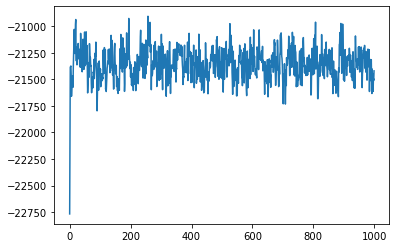

In [20]:
plt.plot(energies)
plt.show()

# Run vanilla MD on ala dipeptide at lambda = 0.5

In [21]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [22]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0.5
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


0.7071067811865476
0.5
0.5


In [23]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [24]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

In [25]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4042681.tmpdir/ipykernel_46127/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
with open("ala_lambda_0.5_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0.5_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0.5_new.npy", "wb") as f:
    np.save(f, positions_new)

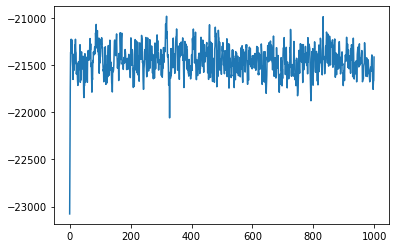

In [27]:
plt.plot(energies)
plt.show()

# Run vanilla MD on ala dipeptide at lambda = 1.0

In [28]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [29]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
0.0
1.0


In [30]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [31]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

In [32]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4042681.tmpdir/ipykernel_46127/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
with open("ala_lambda_1_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_1_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_1_new.npy", "wb") as f:
    np.save(f, positions_new)

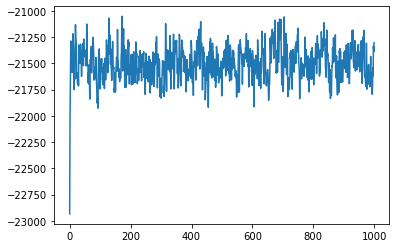

In [34]:
plt.plot(energies)
plt.show()

## Generate dcds

In [38]:
with open("ala_lambda_1_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_old.dcd")
traj[0].save("ala_lambda_1_old.pdb")

In [39]:
with open("ala_lambda_1_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_new.dcd")
traj[0].save("ala_lambda_1_new.pdb")

In [40]:
with open("ala_lambda_0.5_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_old.dcd")
traj[0].save("ala_lambda_0.5_old.pdb")

In [41]:
with open("ala_lambda_0.5_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_new.dcd")
traj[0].save("ala_lambda_0.5_new.pdb")